# MORDM ANALYSIS 

This notebook implements a Multi-Objective Evolutionary Algorithm (MOEA) using the EMA Workbench to evaluate a set of policies under different deeply uncertain scenarios derived from the PRIM analysis. The primary goal is to discover robust policy trade-offs across the multiple KPI's, the in our case five scenarios from problem formulation 2: 
Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EMA Workbench imports
import ema_workbench

from ema_workbench import (Model, Constraint, RealParameter, ScalarOutcome, MultiprocessingEvaluator,ema_logging, Constant, Scenario, HypervolumeMetric,
                           GenerationalDistanceMetric, EpsilonIndicatorMetric,InvertedGenerationalDistanceMetric, SpacingMetric)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, to_problem, ArchiveLogger, epsilon_nondominated)
from ema_workbench.analysis import parcoords
# Problem formulation import
from problem_formulation import get_model_for_problem_formulation 
from ema_workbench.em_framework.optimization import (HypervolumeMetric,GenerationalDistanceMetric,EpsilonIndicatorMetric,InvertedGenerationalDistanceMetric,
                                                     SpacingMetric)

**Constants:**
In the following cell the epsilon values, nfe, outcomes of interest and scenario and archive folder can be set.

epsilon_values: Precision thresholds used by ε-NSGA-II to determine solution dominance.
nfe: Number of function evaluations, metric indicating the computational effort.
outcomes_of_interest: Performance metrics considered during optimization.
scenario_file: Results from the PRIM under which the policies will be optimized
output_dir: folder where the results will be saved

In [34]:
#Constants
output_dir = 'archives'
scenario_file = './data/Selected_Scenarios.csv'
epsilon_values = [[1e6, 1e6, 1e6, 1e6, 10]]
nfe = 40000
outcomes_of_interest = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths'
]

# Optimization Function

This function runs the multi-objective evolutionary algorithm (ε-NSGA-II) optimization for each scenario and multiple random seeds to ensure robust results. It uses the EMA Workbench's MultiprocessingEvaluator for parallel execution.

Steps:
- Creates output directory if missing.
- Loops over all scenarios and seeds.
- Sets up convergence metrics to track optimization progress.
- Runs optimization with a fixed number of function evaluations (nfe).
- Saves results and convergence data to CSV files.
- Collects all results and convergence info for further analysis.

Inputs:
- epsilon: Precision thresholds controlling solution granularity.
- scenarios: List of uncertain future scenarios derived from the PRIM.
- model: The dike model.
- seeds: Number of repetitions to reduce stochastic effects (default 3).

Outputs:
- Lists of optimization results and convergence histories for each run.

In [35]:
def run_optimization(epsilon, scenarios, model, seeds=3):
    
    results = []
    convergences = []

    os.makedirs(output_dir, exist_ok=True)

    with MultiprocessingEvaluator(model) as evaluator:
        for scenario in scenarios:
            for seed in range(seeds):
                # Inside run_optimization()
                convergence_metrics = [
                    ArchiveLogger(
                        output_dir,
                        [lever.name for lever in model.levers],
                        [outcome.name for outcome in model.outcomes],
                        base_filename= "optimization.tar.gz"
                    ),
                    EpsilonProgress()
                ]
                # Optimization
                result, convergence = evaluator.optimize(
                    nfe=nfe,
                    searchover="levers",
                    epsilons=epsilon,
                    constraints=None,
                    convergence=convergence_metrics,
                    reference=scenario
                )

                # Filenames
                result_file = os.path.join(output_dir, f"result__scen{scenario.name}__seed{seed}.csv")
                convergence_file = os.path.join(output_dir, f"convergence__scen{scenario.name}__seed{seed}.csv")

                # Output
                result.to_csv(result_file, index=False)
                pd.DataFrame(convergence).to_csv(convergence_file, index=False)

                # Saving Output
                results.append(result)
                convergences.append(convergence)

    return results, convergences

# Utility Functions for Data Loading and Visualization

This set of helper functions supports the optimization workflow by managing results files, loading scenarios, and visualizing outcomes:

- load_results_from_files(directory)
Scans the given directory for all CSV files prefixed with "result__" and combines them into one pandas DataFrame. This makes it easy to aggregate results from multiple optimization runs for analysis.

- ensure_directory_exists(directory)
Checks if a directory exists and creates it if missing. This prevents errors when saving results or plots.

- load_scenarios(filepath)
Loads scenario definitions from a CSV file where each row represents a scenario with uncertain parameters. Converts each row into a Scenario object for use as a reference in optimization.

- plot_parallel_coordinates(results, eps)
Generates and saves a parallel coordinates plot for key outcome metrics, enabling visual inspection of trade-offs across objectives for the specified epsilon value. This helps to understand the diversity and quality of the Pareto front solutions

In [36]:
def load_results_from_files(directory):
    """
    Loads all optimization result CSVs from a directory into a single DataFrame.
    """
    results = []
    for filename in os.listdir(directory):
        if filename.startswith("result__") and filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            results.append(df)
    return pd.concat(results, ignore_index=True)


def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [37]:
def load_scenarios(filepath):
    df = pd.read_csv(filepath)
    scenarios = []
    for _, row in df.iterrows():
        name = row['scenario']
        parameters = row.drop(labels='scenario').to_dict()
        scenarios.append(Scenario(name, **parameters))
    return scenarios

In [38]:
def plot_parallel_coordinates(results, eps):
    outcomes = results[outcomes_of_interest]
    limits = parcoords.get_limits(outcomes)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(outcomes)
    plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
    plt.savefig(f'parallel_coordinates_eps_{eps}.png')
    plt.show()

**Main Execution Flow**

In the following cell the optimization execution is set up by using the previously defined functions. It sets up logging, ensures the output directory exists, loads the model and scenarios, then runs the optimization for each epsilon value, loads the saved results, and visualizes the trade-offs with parallel coordinates plots.

[MainProcess/INFO] pool started with 24 workers
40100it [15:39, 42.70it/s]                                                     
[MainProcess/INFO] optimization completed, found 254 solutions
40438it [16:30, 40.84it/s]                                                     
[MainProcess/INFO] optimization completed, found 249 solutions
40044it [18:37, 35.83it/s]                                                     
[MainProcess/INFO] optimization completed, found 241 solutions
40615it [19:24, 34.88it/s]                                                     
[MainProcess/INFO] optimization completed, found 399 solutions
40178it [16:55, 39.57it/s]                                                     
[MainProcess/INFO] optimization completed, found 474 solutions
40687it [16:30, 41.07it/s]                                                     
[MainProcess/INFO] optimization completed, found 372 solutions
40096it [15:57, 41.87it/s]                                                     
[MainProcess/I

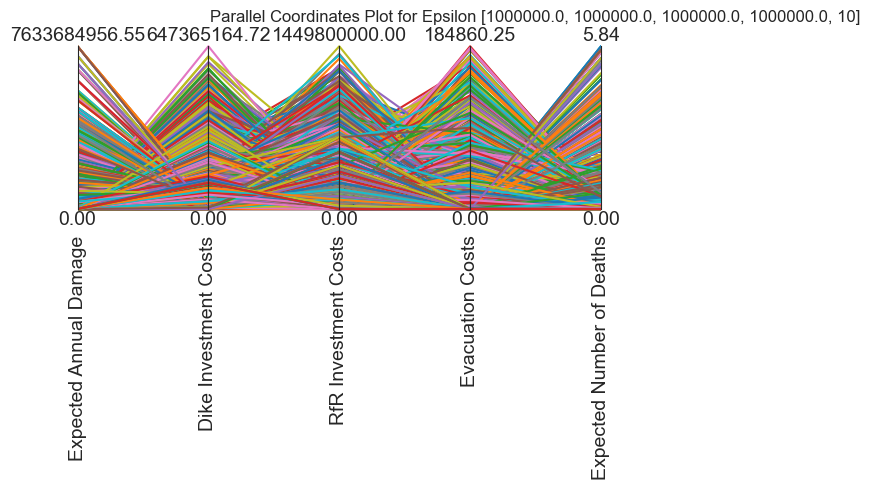

In [39]:
ema_logging.log_to_stderr(ema_logging.INFO)

ensure_directory_exists(output_dir)

model, steps = get_model_for_problem_formulation(2)
scenarios = load_scenarios(scenario_file)

for eps in epsilon_values:
    results, convergences = run_optimization(eps, scenarios, model)
    optimization_results = load_results_from_files(output_dir)
    plot_parallel_coordinates(optimization_results, eps)

**Amount of found policies**

In [40]:
print(len(optimization_results))

4010


# Filtering Pareto-Optimal Policies

Because the optimization was ran for 3 seeds it is possible that not all policies are Pareto-optimal.
This section identifies and filters Pareto-optimal (non-dominated) policies from the optimization results, assuming all objectives are to be minimized. The get_minimizing_policies function returns a boolean mask marking solutions on the Pareto front. The filter_pareto_optimal_policies function applies this mask to keep only those policies. Finally, the filtered Pareto-optimal policies are saved to a CSV file for further analysis.

In [41]:
def get_minimizing_policies(objectives: np.ndarray) -> np.ndarray:
    """
    Return a boolean mask indicating Pareto-optimal (non-dominated) policies.
    Assumes all objectives are to be minimized.
    """
    is_efficient = np.ones(objectives.shape[0], dtype=bool)
    for i, c in enumerate(objectives):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(objectives[is_efficient] < c, axis=1) | np.all(objectives[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [42]:
def filter_pareto_optimal_policies(df, objectives):
    """
    Filters a DataFrame to retain only the Pareto-optimal rows (minimization).
    """
    objective_values = df[objectives].values
    pareto_mask = get_minimizing_policies(objective_values)
    return df[pareto_mask]

In [43]:
pareto_results = filter_pareto_optimal_policies(
    optimization_results, outcomes_of_interest)
pareto_results.to_csv("Pareto_Optimal_Results.csv", index=False)
print("Saved Pareto-optimal policies to pareto_optimal_results.csv")

Saved Pareto-optimal policies to pareto_optimal_results.csv


# Convergence Metrics

In the following cells we attempted to set up and visualize the convergence metrics. However, we were not able to overcome this specific EMA error: 

*EMAError: Parameter names ['0_RfR 0', '0_RfR 1', ..., 'A.5_DikeIncrease 2'] not found in archive*

This error indicates that the parameter names expected by the convergence metric functions do not match those stored in the archive. It likely arises from discrepancies in naming conventions, especially when parameters contain spaces, dots, or digits, which the EMA framework sanitizes internally but the archive files may not reflect.

We tried to resolve this issue by sanitizing parameter names, replacing spaces and dots with underscores and prefixing digits to align the archive columns with EMA’s expectations. However, the error kept coming back, preventing us from fully computing and plotting convergence metrics. To make sure our function does converge without visualizing it, we set the number of function evaluations (nfe) to an extra high number (40,000 instead of the initial 20,000).

Overall, the convergence code is designed to compute several key metrics, such as hypervolume, generational distance, epsilon indicator, inverted generational distance, and spacing. These metrics quantify how well the optimization is converging towards a well-distributed and complete Pareto front as the nfe increases.

The included code uses EMA Workbench’s metric classes to calculate these values for stored archives at different stages of the optimization. The results can then be plotted to visualize the progression of convergence over time.

In [44]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem


def calculate_metrics(archives, reference_set):
    problem = to_problem(model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel(r'$\epsilon$ progress')

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

In [45]:
def sanitize(name):
    name = name.replace(" ", "_").replace(".", "_")
    if name[0].isdigit():
        name = f"p_{name}"
    return name


def compute_metrics_from_archive(archive_path, csv_file, model):
    # Load archive
    archive_df = load_archive_csv(archive_path, csv_file)

    # Extract the problem (includes real parameter and outcome names)
    problem = to_problem(model, searchover="levers")

    # Create mapping from sanitized column names -> original names
    rename_map = {}
    for name in list(problem.parameter_names) + list(problem.outcome_names):
        sanitized = sanitize(name)
        rename_map[sanitized] = name

    # Rename sanitized DataFrame columns back to expected original names
    archive_df.columns = [rename_map.get(col, col)
                          for col in archive_df.columns]

    # Final check: are all needed columns present?
    expected = list(problem.parameter_names) + list(problem.outcome_names)
    missing = [col for col in expected if col not in archive_df.columns]
    if missing:
        raise ValueError(
            f"Missing expected columns in cleaned archive: {missing}")

    # Compute metrics
    hv = HypervolumeMetric(reference_set=archive_df, problem=problem)
    gd = GenerationalDistanceMetric(
        reference_set=archive_df, problem=problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set=archive_df, problem=problem)

    return {"HV": hv(), "GD": gd(), "EI": ei()}

In [46]:
 # your EMA model
metrics = compute_metrics_from_archive(
    archive_path="./archives/optimization.tar.gz",
    csv_file="tmp/100.csv",
    model=model
)

print(metrics)

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive